# Data 604 Final Project

The inspiration for this simulation comes from a mountain town about an hour away from where I live in California. There are two seasons where they have an influx of tourists: Summer and Winter. Summer for the lake and winter for skiing on the mountain.

Whenever I would visit, all the restaraunts seemed understaffed to handle the influx of tourists. I want to find out given certain parameters what is the optimal number of waiters to flip the most revenue. One obstacle a lot of these restaurants face is that labor is hard to come by since there aren't many locals there year around. So we want to find the lowest number possible. 

In [264]:
import random
from modsim import *
import pint

### Parameters

Below are the parameters in our system. Most of them are estimates or averages I looked up online (E.g. that a waiter handles 3 tables at a time). For every 2 waiters there needs to be 1 bus boy. Capacity is the total number of tables a restaurant has. There is a list called "tables" that we will use to sit people down and remove them when they are done eating. The time variables are measured in minutes.

In [369]:
restaurant = System(
    t_0 = 0,
    t_end = 720,
    waiter_num = 4,
    bus_boy_num = 2,
    table_per_server = 3,
    capacity = 60,
    waiter_salary = 15,
    bus_boy_salary = 12,
    queue = 0,
    table_revenue = 100,
    total_revenue = 0,
    left_customers = 0,
    tables = []
)

### Add to queue

This function checks what time of day it is and adds a random number of people in the queue. If it's peak hours the random number is higher.

In [395]:
def add_to_queue(time):
    if (time >= 60 and time <= 180) or (time >= 360 and time <= 540):
        restaurant.queue = restaurant.queue + random.randint(8,10)
    else:
        restaurant.queue = restaurant.queue + random.randint(3,4)

### Help Tables

When someone is sat down at a table they are marked as a "1" in the tables list. For example [1,1,1,1] would be four people sitting down at the table. Each loop in the simulation will be in 15 min intervals. I'm making the assumption that a waiter has to visit a table 6 times before they get their check and leave. That means without any interuptions a party will stay for 1 hr 30 minutes. But, if the there are more people seated than the waiters can handle a particular table might not be helped in the 15 minutes interval. Making them stay longer.

The function below checks how many waiters there are and increments the people seated by 1. If the waiters are understaffed they help [number of waters] * [tables per waiter] at random.

In [396]:
def help_tables(tables, num_servers, table_per_server):
    
    tables_helped = num_servers*table_per_server
   
    if tables_helped >= len(tables):
        tables = [x + 1 for x in tables]
        restaurant.tables = tables
    else:
        random.shuffle(tables)
        tables1 = tables[0:tables_helped]
        tables2 = tables[tables_helped:len(tables)]
        
        tables1 = [x + 1 for x in tables1]
        tables = tables1 +tables2
        restaurant.tables = tables

### Add to Tables

This function checks the queue and capacity to add people to tables accordingly

In [397]:
def add_to_tables(tables, queue):
    tables_left = restaurant.capacity - len(tables) 
    
    if tables_left > queue:
        added_tables = [1] * queue
        restaurant.queue = 0
        restaurant.tables = tables + added_tables
    else:
        added_tables = [1] * tables_left
        restaurant.queue = queue - tables_left
        restaurant.tables = tables + added_tables
        

### Leave Tables

Once someone has been helped 6 times they are removed from the table to clear up capacity

In [398]:
def leave_tables(tables):
    restaurant.total_revenue = restaurant.total_revenue + len([value for value in tables if value == 6]) * restaurant.table_revenue
    return [value for value in tables if value != 6]

### Run Simulation

This wraps all the functions together and loops through 1 day given the parameters

In [406]:
def run_simulation(restaurant):
    for i in range(restaurant.t_0,restaurant.t_end+1,15):
        add_to_queue(i)

        if restaurant.queue > 20:
            restaurant.left_customers = restaurant.left_customers + (restaurant.queue - 10)
            restaurant.queue = 20

        help_tables(restaurant.tables, restaurant.waiter_num, restaurant.table_per_server)

        add_to_tables(restaurant.tables, restaurant.queue)

        restaurant.tables = leave_tables(restaurant.tables)
    
    return restaurant

### Iterate through number of servers

This runs the simulation with different server counts to see which produces the most revenue

In [408]:
total_revenue = SweepSeries()
net_revenue = SweepSeries()

for i in range(2, 20):
    restaurant = System(
        t_0 = 0,
        t_end = 720,
        waiter_num = i,
        bus_boy_num = int(i/2),
        table_per_server = 3,
        capacity = 60,
        waiter_salary = 15,
        bus_boy_salary = 12,
        queue = 0,
        table_revenue = 100,
        total_revenue = 0,
        left_customers = 0,
        tables = []
    )
    
    run_simulation(restaurant)
    
    total_revenue[restaurant.waiter_num] = restaurant.total_revenue
    net_revenue[restaurant.waiter_num] = restaurant.total_revenue - (restaurant.waiter_num * restaurant.waiter_salary * 11) - (restaurant.bus_boy_num * restaurant.bus_boy_salary * 11)

### Results

As we increase the number of servers we can see almost a linear increase in revenue until we hit around 10 servers. The net revenue gives a better look, because when we hit around 10 servers the net revenue almost flattens. So, given our parameters are realistic I would have 10 servers on pay roll going into peak season.

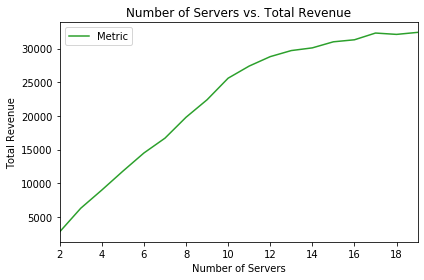

In [413]:
total_revenue.plot(color='C2')

decorate(xlabel='Number of Servers',
         ylabel='Total Revenue',
         title='Number of Servers vs. Total Revenue')

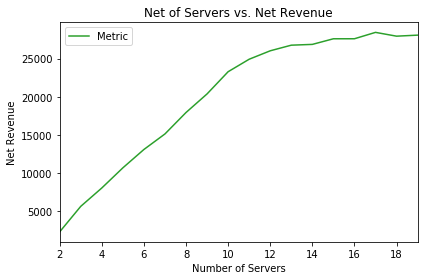

In [415]:
net_revenue.plot(color='C2')

decorate(xlabel='Number of Servers',
         ylabel='Net Revenue',
         title='Net of Servers vs. Net Revenue')